6/14/20 This notebook worked with stack version 2020_11

In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lsst.afw.cameraGeom import FIELD_ANGLE, PIXELS
from lsst.daf.persistence import Butler

from lsst.sims.utils import angularSeparation

from ast import literal_eval

### Load the data needed

In [2]:
dd = pd.read_csv('../raftInstall.csv',index_col=0)

In [3]:
DATADIR = f"{os.environ['OBS_LSST_DIR']}/lsstcam/CALIB" 
print(DATADIR)
butler = Butler(DATADIR)
cam = butler.get('camera')

/home/bxin/lsst_stack/obs_lsst/lsstcam/CALIB


### Prepare vignetting function

In [4]:
# below we use v3.11 values
vfile = f"{os.environ['HOME']}/notebooks/f_factors/data/vignettingF.txt"
M1D = 8.36 #clear aperture as in Optical design
aa = np.loadtxt(vfile, skiprows=12)
vr = aa[:,0]
vv = aa[:,1]

### Create the dataframe

In [5]:
filters = ['u', 'g', 'r', 'i', 'z', 'y']
properties = ['vendor', 'CCD', 'EO_run','ampX(pixel)', 'ampY(pixel)', 'ampX(deg)', 'ampY(deg)', 'fieldR(deg)', 'gain', 'readnoise', 
              'vignetting', 'effarea(m^2)']+ ['m5_%s'%i for i in filters] + ['fS'] + ['u1'] + ['u2'] \
     + ['T%s'%i for i in filters] + ['S%s'%i for i in filters] 
amps = ()
for det in cam:
    rname, dname = det.getName().split('_')
    if len(rname)>3:
        continue
    if np.isnan(dd.run[rname]):
        print('no data yet, use default', rname, dname)
        continue
    for i in range(8):
        amps = amps + ('%s_%s_C1%d'%(rname,dname,i),)
    for i in range(8):
        amps = amps + ('%s_%s_C0%d'%(rname,dname,7-i),)
mdf = pd.DataFrame(index=amps, columns=properties, dtype=object)

no data yet, use default R00 SG0
no data yet, use default R00 SG1
no data yet, use default R00 SW0
no data yet, use default R00 SW1
no data yet, use default R04 SG0
no data yet, use default R04 SG1
no data yet, use default R04 SW0
no data yet, use default R04 SW1
no data yet, use default R40 SG0
no data yet, use default R40 SG1
no data yet, use default R40 SW0
no data yet, use default R40 SW1
no data yet, use default R44 SG0
no data yet, use default R44 SG1
no data yet, use default R44 SW0
no data yet, use default R44 SW1


### Fill the dataframe

In [6]:
for det in cam:
    rname, dname = det.getName().split('_')
    if len(rname)>3:
        continue
    if np.isnan(dd.run[rname]):
        print('no data yet, use default', rname, dname)
        continue
    vendor = det.getSerial()[:3]
    ccdname = det.getSerial()
    for iamp, amp in enumerate(det):
        i = amp.getName()
        idx = '%s_%s_%s'%(rname,dname,i)
        mdf.loc[idx, 'vendor'] = vendor
        mdf['CCD'].loc[idx]  = ccdname
        mdf['EO_run'][idx]  = int(dd.run[rname])
        amp_point = amp.getBBox().getCenter()
        mdf['ampX(pixel)'].loc[idx] = amp_point.x
        mdf['ampY(pixel)'].loc[idx] = amp_point.y
        raDec = det.transform(amp_point, PIXELS, FIELD_ANGLE) 
        [mdf['ampX(deg)'].loc[idx], mdf['ampY(deg)'].loc[idx]] = np.round(np.degrees(raDec),4)
        radius = angularSeparation(0., 0., mdf['ampX(deg)'][idx], mdf['ampY(deg)'][idx])
        mdf['fieldR(deg)'].loc[idx] = np.round(radius,4)
        mdf['gain'].loc[idx] = np.round(amp.getGain(),4)
        mdf['readnoise'].loc[idx] = np.round(amp.getReadNoise(),4)
        mdf['vignetting'].loc[idx] = np.round(np.interp(radius, vr, vv),4)
        mdf['effarea(m^2)'].loc[idx] = np.round(mdf['vignetting'][idx]*np.pi*(M1D/2)**2,3)
        
        #Richard's Heatmap tool accepts C10-17-07-00. Therefore, our list in csv files have been ordered the same
        ii = iamp
        dfDir = os.path.join('../m5_output', rname)
        #print(iamp, i,ii)
        
        #test we got the order right:
        #dfPath = os.path.join(dfDir, 'adf_%s.csv'%rname)
        #df = pd.read_csv(dfPath, index_col=0)     
        #print(mdf['readnoise'].loc[idx], df[idx[:7]].apply(literal_eval)['readnoise'][ii] )
        
        dfPath = os.path.join(dfDir, 'm5df_%s.csv'%rname)
        df = pd.read_csv(dfPath, index_col=0)
        for f in filters:
            mdf['m5_%s'%f].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)[f][ii],3)
        mdf['fS'].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)['fS'][ii],3)
        mdf['u1'].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)['u1'][ii],3)
        mdf['u2'].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)['u2'][ii],3)
            
        dfPath = os.path.join(dfDir, 'Tdf_%s.csv'%rname)
        df = pd.read_csv(dfPath, index_col=0)
        for f in filters:
            mdf['T%s'%f].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)[f][ii],3)
            
        dfPath = os.path.join(dfDir, 'Sdf_%s.csv'%rname)
        df = pd.read_csv(dfPath, index_col=0)
        for f in filters:
            mdf['S%s'%f].loc[idx] = np.round(df[idx[:7]].apply(literal_eval)[f][ii],3)
    #break

no data yet, use default R00 SG0
no data yet, use default R00 SG1
no data yet, use default R00 SW0
no data yet, use default R00 SW1
no data yet, use default R04 SG0
no data yet, use default R04 SG1
no data yet, use default R04 SW0
no data yet, use default R04 SW1
no data yet, use default R40 SG0
no data yet, use default R40 SG1
no data yet, use default R40 SW0
no data yet, use default R40 SW1
no data yet, use default R44 SG0
no data yet, use default R44 SG1
no data yet, use default R44 SW0
no data yet, use default R44 SW1


In [7]:
mdf[:].loc['R30_S00_C10']

vendor                     E2V
CCD             E2V-CCD250-237
EO_run                   11063
ampX(pixel)              255.5
ampY(pixel)             3002.5
ampX(deg)              -1.7455
ampY(deg)               0.5301
fieldR(deg)             1.8242
gain                   55.8557
readnoise              190.839
vignetting              0.4784
effarea(m^2)             26.26
m5_u                        -1
m5_g                        -1
m5_r                        -1
m5_i                        -1
m5_z                        -1
m5_y                        -1
fS                          -1
u1                          -1
u2                          -1
Tu                          -1
Tg                          -1
Tr                          -1
Ti                          -1
Tz                          -1
Ty                          -1
Su                          -1
Sg                          -1
Sr                          -1
Si                          -1
Sz                          -1
Sy      

In [8]:
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  
mdf[1600:1600+16]

,vendor,CCD,EO_run,ampX(pixel),ampY(pixel),ampX(deg),ampY(deg),fieldR(deg),gain,readnoise,vignetting,effarea(m^2),m5_u,m5_g,m5_r,m5_i,m5_z,m5_y,fS,u1,u2,Tu,Tg,Tr,Ti,Tz,Ty,Su,Sg,Sr,Si,Sz,Sy
R23_S01_C10,E2V,E2V-CCD250-239,11852,255.5,3002.5,0.6061,-0.1812,0.6326,1.1662,5.2779,0.621,34.087,24.296,24.991,24.503,24.027,23.422,22.461,1.247,24.783,25.225,0.042,0.135,0.114,0.081,0.054,0.024,0.067,0.164,0.128,0.089,0.058,0.028
R23_S01_C11,E2V,E2V-CCD250-239,11852,767.5,3002.5,0.6345,-0.1812,0.6599,1.17,5.3742,0.6207,34.071,24.293,24.99,24.502,24.027,23.422,22.461,1.245,24.782,25.226,0.042,0.135,0.114,0.081,0.054,0.024,0.068,0.165,0.128,0.089,0.058,0.028
R23_S01_C12,E2V,E2V-CCD250-239,11852,1279.5,3002.5,0.6629,-0.1812,0.6872,1.1793,5.3333,0.6201,34.038,24.298,24.99,24.501,24.026,23.421,22.46,1.245,24.785,25.229,0.043,0.135,0.114,0.081,0.054,0.024,0.068,0.165,0.128,0.089,0.058,0.028
R23_S01_C13,E2V,E2V-CCD250-239,11852,1791.5,3002.5,0.6914,-0.1812,0.7147,1.1787,5.317,0.6202,34.043,24.3,24.991,24.501,24.026,23.421,22.459,1.245,24.787,25.23,0.043,0.135,0.114,0.081,0.054,0.024,0.068,0.165,0.128,0.089,0.058,0.028
R23_S01_C14,E2V,E2V-CCD250-239,11852,2303.5,3002.5,0.7198,-0.1812,0.7423,1.1909,5.4045,0.6198,34.022,24.298,24.99,24.501,24.026,23.421,22.459,1.245,24.787,25.231,0.043,0.136,0.114,0.081,0.054,0.024,0.069,0.165,0.128,0.089,0.058,0.028
R23_S01_C15,E2V,E2V-CCD250-239,11852,2815.5,3002.5,0.7483,-0.1812,0.7699,1.1866,5.3916,0.6198,34.022,24.305,24.993,24.504,24.028,23.423,22.462,1.252,24.792,25.236,0.043,0.136,0.114,0.082,0.055,0.024,0.069,0.166,0.128,0.089,0.058,0.028
R23_S01_C16,E2V,E2V-CCD250-239,11852,3327.5,3002.5,0.7767,-0.1812,0.7976,1.1867,5.3358,0.6194,34,24.304,24.99,24.5,24.025,23.42,22.458,1.245,24.791,25.234,0.043,0.135,0.113,0.081,0.054,0.024,0.069,0.165,0.127,0.089,0.058,0.028
R23_S01_C17,E2V,E2V-CCD250-239,11852,3839.5,3002.5,0.8052,-0.1812,0.8253,1.1945,5.4293,0.6191,33.983,24.3,24.989,24.5,24.025,23.421,22.459,1.244,24.789,25.233,0.043,0.136,0.114,0.081,0.054,0.024,0.069,0.165,0.128,0.089,0.058,0.028
R23_S01_C07,E2V,E2V-CCD250-239,11852,3839.5,1000.5,0.8052,-0.2924,0.8566,1.1817,5.4649,0.6185,33.95,24.303,24.985,24.495,24.024,23.423,22.461,1.245,24.792,25.237,0.043,0.135,0.113,0.081,0.055,0.024,0.07,0.164,0.127,0.089,0.058,0.028
R23_S01_C06,E2V,E2V-CCD250-239,11852,3327.5,1000.5,0.7767,-0.2924,0.8299,1.1761,5.4381,0.6189,33.972,24.307,24.988,24.498,24.026,23.425,22.462,1.25,24.795,25.239,0.044,0.136,0.113,0.082,0.055,0.024,0.07,0.165,0.127,0.089,0.058,0.028


In [9]:
mdf[:].loc['R30_S00_C10']

vendor                     E2V
CCD             E2V-CCD250-237
EO_run                   11063
ampX(pixel)              255.5
ampY(pixel)             3002.5
ampX(deg)              -1.7455
ampY(deg)               0.5301
fieldR(deg)             1.8242
gain                   55.8557
readnoise              190.839
vignetting              0.4784
effarea(m^2)             26.26
m5_u                        -1
m5_g                        -1
m5_r                        -1
m5_i                        -1
m5_z                        -1
m5_y                        -1
fS                          -1
u1                          -1
u2                          -1
Tu                          -1
Tg                          -1
Tr                          -1
Ti                          -1
Tz                          -1
Ty                          -1
Su                          -1
Sg                          -1
Sr                          -1
Si                          -1
Sz                          -1
Sy      

In [10]:
189*16

3024

In [11]:
len(amps)

3024

In [12]:
dfPath = os.path.join('../m5_output', 'm5_master_db.csv')
mdf.to_csv(dfPath)

In [13]:
dfPath

'../m5_output/m5_master_db.csv'

In [14]:
for f in filters:
    idx = mdf['m5_%s'%f]>0
    a = sum(idx)
    b = sum(mdf['m5_%s'%f]>-100)
    c = np.median(mdf['m5_%s'%f])
    d = np.median(mdf.loc[idx, 'm5_%s'%f])
    m1 = np.mean(mdf['m5_%s'%f])
    m2 = np.mean(mdf.loc[idx, 'm5_%s'%f])
    print('%s, %.0f/%.0f = %.3f, medianAll = %.1f, medianLive = %.1f, MeanAll = %.1f, meanLive = %.1f'%(f, a,b,a/b, c, d, m1, m2))

u, 3021/3024 = 0.999, medianAll = 24.2, medianLive = 24.2, MeanAll = 24.1, meanLive = 24.1
g, 3021/3024 = 0.999, medianAll = 25.0, medianLive = 25.0, MeanAll = 24.9, meanLive = 24.9
r, 3021/3024 = 0.999, medianAll = 24.5, medianLive = 24.5, MeanAll = 24.4, meanLive = 24.4
i, 3021/3024 = 0.999, medianAll = 24.0, medianLive = 24.0, MeanAll = 24.0, meanLive = 24.0
z, 3021/3024 = 0.999, medianAll = 23.4, medianLive = 23.4, MeanAll = 23.4, meanLive = 23.4
y, 3021/3024 = 0.999, medianAll = 22.5, medianLive = 22.5, MeanAll = 22.4, meanLive = 22.5


In [15]:
mdf['vignetting'].max()

0.6225

In [16]:
mdf['m5_u']['R30_S00_C10']

-1.0

In [17]:
mdf['Tu']['R30_S00_C10']

-1.0

In [18]:
mdf['Su']['R10_S00_C00']

-1.0

In [19]:
mdf['m5_u']['R01_S01_C00']

-1.0

In [30]:
idxe2v = (mdf['vendor'] == 'E2V') & (mdf['u1']>0)
idxitl = (mdf['vendor'] == 'ITL') & (mdf['u1']>0)

In [37]:
d0 = np.mean(mdf.loc[idxe2v, 'm5_u']) - np.mean(mdf.loc[idxitl, 'm5_u'])
d1 = np.mean(mdf.loc[idxe2v, 'u1']) - np.mean(mdf.loc[idxitl, 'u1'])
d2 = np.mean(mdf.loc[idxe2v, 'u2']) - np.mean(mdf.loc[idxitl, 'u2'])
print('%.2f, %.2f, %.2f'%(d0, d1, d2))

0.33, 0.26, 0.20


In [49]:
dn = np.mean(mdf.loc[idxe2v, 'readnoise']) - np.mean(mdf.loc[idxitl, 'readnoise'])

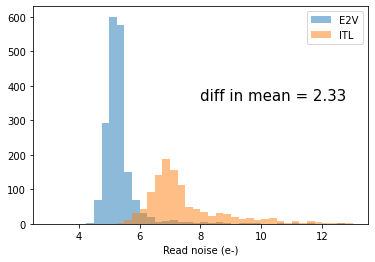

In [83]:
bins = np.linspace(3, 13,41)
plt.hist(mdf.loc[idxe2v,'readnoise'], bins, alpha = 0.5, label='E2V')
plt.hist(mdf.loc[idxitl,'readnoise'], bins, alpha = 0.5, label='ITL')
plt.legend()
plt.text(8, 358, 'diff in mean = %.2f'%(-dn), color = 'black', fontsize=15)
plt.xlabel('Read noise (e-)');

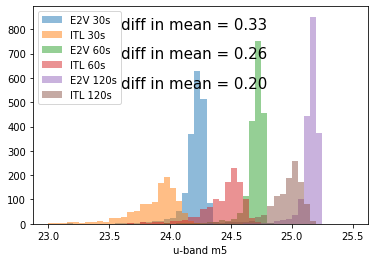

In [82]:
bins=np.linspace(23, 25.5, 51)
plt.hist(mdf.loc[idxe2v,'m5_u'], bins, alpha = 0.5, label='E2V 30s')
plt.hist(mdf.loc[idxitl,'m5_u'], bins, alpha = 0.5, label='ITL 30s')
plt.hist(mdf.loc[idxe2v,'u1'], bins, alpha = 0.5, label='E2V 60s') 
plt.hist(mdf.loc[idxitl,'u1'], bins, alpha = 0.5, label='ITL 60s')
plt.hist(mdf.loc[idxe2v,'u2'], bins, alpha = 0.5, label='E2V 120s')
plt.hist(mdf.loc[idxitl,'u2'], bins, alpha = 0.5, label='ITL 120s')
plt.xlabel('u-band m5')
plt.text(23.6, 800, 'diff in mean = %.2f'%(d0), color = 'black', fontsize=15)
plt.text(23.6, 680, 'diff in mean = %.2f'%(d1), color = 'black', fontsize=15)
plt.text(23.6, 560, 'diff in mean = %.2f'%(d2), color = 'black', fontsize=15)
plt.legend();